In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.verbosity = 0
import scipy
#from numpy.linalg import svd
import gseapy as gp

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

In [2]:
try:
    from sys import path as syspath
    from os import path as ospath
    syspath.append(ospath.join(ospath.expanduser("~"), 'Documents/git/Xct'))

    from scTenifoldXct.main import *
    import scTenifoldXct.dNN as dNN    
    import scTenifoldXct.visualization as vis
    
except ImportError:
    print('Module not found')

In [3]:
ada = sc.read_h5ad("../data/lung_processed.h5ad")
ada

AnnData object with n_obs × n_vars = 4356 × 3000
    obs: 'cell_well', 'batch', 'n_genes', 'leiden', 'cell_type', 'ident'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'n_cells'
    uns: 'batch_colors', 'cell_type_colors', 'ident_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log1p', 'raw'
    obsp: 'connectivities', 'distances'

In [4]:
ada.obs['ident'].value_counts()

Basophil_KO                 1284
Basophil_WT                 1152
Macrophage2                  489
Neutrophil                   315
Endothelium                  294
Matrix fibroblast            154
AT1                          117
Smooth muscle fibroblast     110
Macrophage1                  101
T cell                        97
AT2                           92
Basophil                      82
B cell                        69
Name: ident, dtype: int64

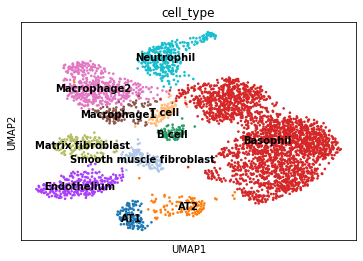

In [5]:
sc.pl.umap(ada, color='cell_type', legend_loc='on data')

## WT & KO obj:

In [6]:
# obj1 = Xct(ada, 'AT2', 'Basophil_WT', build_GRN = True, save_GRN = True, 
#            pcNet_name = 'net_AT2Baso_WT', mode = 'full', verbose = True)

obj1 = Xct(ada, 'AT2', 'Basophil_WT', specis='Mouse' ,build_GRN = False,
           pcNet_name = 'net_AT2Baso_WT')

print(obj1)

Xct object for interactions from AT2 (92) to Basophil_WT (1152)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [7]:
df1 = obj1.fill_metric()
len(df1)

785

In [8]:
# obj2 = Xct(ada, 'AT2', 'Basophil_KO', build_GRN = True, save_GRN = True,
#            pcNet_name = 'net_AT2Baso_KO', mode = 'full', verbose = True)

obj2 = Xct(ada, 'AT2', 'Basophil_KO', specis = 'Mouse', build_GRN = False,
           pcNet_name = 'net_AT2Baso_KO')

print(obj2)

Xct object for interactions from AT2 (92) to Basophil_KO (1284)
# of genes = 3000 X 3000 
Correspondence = 6000 X 6000


In [9]:
df2 = obj2.fill_metric()
len(df2)

720

In [10]:
#selected LR pairs
candidates1 = get_candidates(df1)
print(len(candidates1))

candidates2 = get_candidates(df2)
print(len(candidates2))

785
720


In [11]:
candidates_union = list(set(candidates1).union(set(candidates2)))
len(candidates_union)

817

In [12]:
candidates_inter = list(set(candidates1).intersection(set(candidates2)))
len(candidates_inter)

688

In [13]:
obj1._w.shape, obj2._w.shape

((6000, 6000), (6000, 6000))

1:

In [ ]:
counts_np1 = get_counts_np(obj1)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape

In [ ]:
projections1, losses1 = dNN.train_and_project(counts_np1, obj1._w, dim = 2, steps = 1000, lr = 0.01)

In [ ]:
df_nn1 = nn_aligned_dist(obj1, projections1)
df_nn1

In [ ]:
df_enriched1 = chi2_test(df_nn1, df = 1, pval = 0.05, FDR = True, candidates = candidates1)

df_enriched1

In [ ]:
null_test(df_nn1, pval=2.5, candidates = candidates1)

2:

In [ ]:
counts_np2 = get_counts_np(obj2)
len(counts_np2), counts_np2[0].shape, counts_np2[1].shape

In [ ]:
projections2, losses2 = dNN.train_and_project(counts_np2, obj2._w, dim = 2, steps = 1000, lr = 0.01)

In [ ]:
df_nn2 = nn_aligned_dist(obj2, projections2)
df_nn2

In [ ]:
df_enriched2 = chi2_test(df_nn2, df = 1, pval = 0.05, FDR = True, candidates = candidates2)

df_enriched2

In [ ]:
null_test(df_nn2, pval=2.5, candidates = candidates2)

merged:

In [14]:
counts_np1 = get_counts_np(obj1, obj2)
len(counts_np1), counts_np1[0].shape, counts_np1[1].shape, counts_np1[2].shape, counts_np1[3].shape

(4, (3000, 92), (3000, 1152), (3000, 92), (3000, 1284))

In [15]:
W = build_W(obj1, obj2)
W.shape

(12000, 12000)

In [16]:
projections, losses = dNN.train_and_project(counts_np1, w = W, dim = 3, steps = 1000, lr = 0.01)

Net(
  (linear1): Linear(in_features=92, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=3, bias=True)
)
Net(
  (linear1): Linear(in_features=1152, out_features=232, bias=True)
  (linear2): Linear(in_features=232, out_features=58, bias=True)
  (linear3): Linear(in_features=58, out_features=3, bias=True)
)
Net(
  (linear1): Linear(in_features=92, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (linear3): Linear(in_features=16, out_features=3, bias=True)
)
Net(
  (linear1): Linear(in_features=1284, out_features=248, bias=True)
  (linear2): Linear(in_features=248, out_features=62, bias=True)
  (linear3): Linear(in_features=62, out_features=3, bias=True)
)
1 17083.244140625
10 9160.3173828125
20 8455.404296875
30 7921.701171875
40 7650.80615234375
50 7406.21875
60 7173.74853515625
70 6978.48876953125
80 6839.6943359375
90 6743.69189453125
100 6679.94726

In [17]:
projections.shape

(12000, 3)

In [18]:
projections_split = np.array_split(projections, 2) #return a list of ndarray
projections_split[0].shape, projections_split[1].shape

((6000, 3), (6000, 3))

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig, ax = plt.subplots(figsize=(8,8), dpi=80)
ax = Axes3D(fig)


ax.scatter(projections_split[0][:3000, 0], projections_split[0][:3000, 1], projections_split[0][:3000, 2], c='red')
ax.scatter(projections_split[0][3000:, 0], projections_split[0][3000:, 1], projections_split[0][3000:, 2], c='blue')

ax.scatter(projections_split[1][:3000, 0], projections_split[1][:3000, 1], projections_split[1][:3000, 2], c='black')
ax.scatter(projections_split[1][3000:, 0], projections_split[1][3000:, 1], projections_split[1][3000:, 2], c='green')


plt.show()

In [19]:
df_nn1 = nn_aligned_dist(obj1, projections_split[0])
df_nn2 = nn_aligned_dist(obj2, projections_split[1])

df_nn1.head()

computing pair-wise euclidean distances...
adding column 'correspondence'...
computing pair-wise euclidean distances...
adding column 'correspondence'...


,ligand,receptor,dist,correspondence
Sftpc_Sftpc,Sftpc,Sftpc,0.001548,799.811829
Sftpc_Ngp,Sftpc,Ngp,0.009601,16.784599
Sftpc_Hbb-b1,Sftpc,Hbb-b1,0.002423,3949.006836
Sftpc_Hbb-b2,Sftpc,Hbb-b2,0.002291,1913.099243
Sftpc_Hba-a1,Sftpc,Hba-a1,0.002301,2579.580566


In [20]:
df_nn2.head()

,ligand,receptor,dist,correspondence
Sftpc_Sftpc,Sftpc,Sftpc,0.000878,524.500427
Sftpc_Ngp,Sftpc,Ngp,0.010599,3.958462
Sftpc_Hbb-b1,Sftpc,Hbb-b1,0.001978,1849.531982
Sftpc_Hbb-b2,Sftpc,Hbb-b2,0.001558,948.579529
Sftpc_Hba-a1,Sftpc,Hba-a1,0.001769,1186.088013


In [21]:
df_nn_all = nn_aligned_dist_diff(df_nn2, df_nn1)

df_nn_all

computing pair-wise distance differences...
adding column 'diff2'...


,ligand,receptor,dist,correspondence,dist,correspondence,diff2
Sftpc_Sftpc,Sftpc,Sftpc,0.000878,524.500427,0.001548,799.811829,4.485315e-07
Sftpc_Ngp,Sftpc,Ngp,0.010599,3.958462,0.009601,16.784599,9.965814e-07
Sftpc_Hbb-b1,Sftpc,Hbb-b1,0.001978,1849.531982,0.002423,3949.006836,1.977030e-07
Sftpc_Hbb-b2,Sftpc,Hbb-b2,0.001558,948.579529,0.002291,1913.099243,5.372620e-07
Sftpc_Hba-a1,Sftpc,Hba-a1,0.001769,1186.088013,0.002301,2579.580566,2.825109e-07
...,...,...,...,...,...,...,...
AF064781_Gm10642,AF064781,Gm10642,0.022396,0.002015,0.022292,0.003131,1.087952e-08
AF064781_Tesk2,AF064781,Tesk2,0.030043,0.000827,0.031108,0.000000,1.132983e-06
AF064781_2410133F24Rik,AF064781,2410133F24Rik,0.022860,0.001806,0.022618,0.004649,5.863668e-08
AF064781_Ccl11,AF064781,Ccl11,0.031122,0.000788,0.031399,0.000879,7.697049e-08


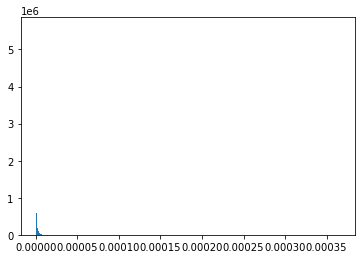

In [22]:
plt.hist(df_nn_all['diff2'], bins=1000)
plt.show()

In [23]:
df_enriched_diff = chi2_diff_test(df_nn_all, df=1, pval=0.05, FDR=True, candidates=candidates_union)
df_enriched_diff


Total enriched: 7 / 9000000


,ligand,receptor,dist,correspondence,dist,correspondence,diff2,FC,p_val,q_val,enriched_rank,dir,dir_sign
Il33_Il1rl1,Il33,Il1rl1,0.022452,0.000000,0.004787,8.879311,0.000312,342.450075,0.000000e+00,0.000000,1,0,↓
Edn3_Ednrb,Edn3,Ednrb,0.016199,0.055208,0.011017,0.709435,0.000027,29.469606,5.680052e-08,0.000062,2,0,↓
Edn1_Ednrb,Edn1,Ednrb,0.015956,0.080284,0.010783,1.031674,0.000027,29.376494,5.959613e-08,0.000064,3,0,↓
Csf2_Tnf,Csf2,Tnf,0.010772,0.248127,0.007111,3.329928,0.000013,14.710360,1.253556e-04,0.029136,4,0,↓
Csf1_Tnf,Csf1,Tnf,0.012638,0.165156,0.008984,2.216438,0.000013,14.646857,1.296506e-04,0.029854,5,0,↓
Stc1_Tnf,Stc1,Tnf,0.012432,0.159443,0.008785,2.139763,0.000013,14.602162,1.327621e-04,0.030358,6,0,↓
Angpt1_Tnf,Angpt1,Tnf,0.015136,0.054766,0.011646,0.734972,0.000012,13.364955,2.563701e-04,0.048282,7,0,↓


In [ ]:
# df_enriched_diff.to_excel('Baso_R_KO.xlsx')

#### GSEA:

In [24]:
genelist = get_genelist(df_enriched_diff)
len(genelist)

10

In [27]:
import gseapy as gp

enr = gp.enrichr(gene_list= genelist,
                 gene_sets='GO_Biological_Process_2021',
                 organism='Human', 
                 outdir=None, #'enrichr_kegg',
                 no_plot=True,
                 cutoff=0.05 
                )

In [28]:
enr.results.head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,vascular associated smooth muscle contraction ...,3/8,5.033266e-09,0.000002,0,0,1713.000000,32730.628194,EDN1;EDNRB;EDN3
1,GO_Biological_Process_2021,vasoconstriction (GO:0042310),3/11,1.481876e-08,0.000003,0,0,1070.464286,19297.657681,EDN1;EDNRB;EDN3
2,GO_Biological_Process_2021,phasic smooth muscle contraction (GO:0014821),3/12,1.975326e-08,0.000003,0,0,951.476190,16879.137629,EDN1;EDNRB;EDN3
3,GO_Biological_Process_2021,positive regulation of oxidoreductase activity...,3/19,8.684639e-08,0.000010,0,0,535.017857,8698.922199,EDN1;EDN3;TNF
4,GO_Biological_Process_2021,positive regulation of cell communication (GO:...,3/28,2.929226e-07,0.000025,0,0,342.257143,5148.696483,EDN1;EDN3;TNF
5,GO_Biological_Process_2021,positive regulation of leukocyte migration (GO...,3/29,3.266361e-07,0.000025,0,0,329.076923,4914.572706,EDN3;CSF1;TNF
6,GO_Biological_Process_2021,blood vessel diameter maintenance (GO:0097746),3/35,5.841497e-07,0.000035,0,0,267.294643,3836.509036,EDN1;EDNRB;EDN3
7,GO_Biological_Process_2021,positive regulation of macromolecule metabolic...,5/384,5.918097e-07,0.000035,0,0,51.744063,742.014043,IL33;CSF2;CSF1;ANGPT1;TNF
8,GO_Biological_Process_2021,regulation of cell differentiation (GO:0045595),4/156,7.210580e-07,0.000035,0,0,87.008772,1230.525582,CSF2;EDN3;CSF1;TNF
9,GO_Biological_Process_2021,positive regulation of signaling (GO:0023056),3/38,7.523331e-07,0.000035,0,0,244.346939,3445.313004,EDN1;EDN3;TNF


In [ ]:
# enr.results.to_excel('Baso_compare_enrichr.xlsx')

#### visualization:

In [29]:
Xct.add_names_to_nets(obj1)
Xct.add_names_to_nets(obj2)

completed.
completed.


In [30]:
targets = vis.get_Xct_pairs(df_enriched_diff)
targets

(['Il33', 'Il1rl1'],
 ['Edn3', 'Ednrb'],
 ['Edn1', 'Ednrb'],
 ['Csf2', 'Tnf'],
 ['Csf1', 'Tnf'],
 ['Stc1', 'Tnf'],
 ['Angpt1', 'Tnf'])

In [31]:
scale_factor = 30

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

graphs merged: 
# of nodes: 42, # of edges: 40

edge from Il33 to Il1rl1 added


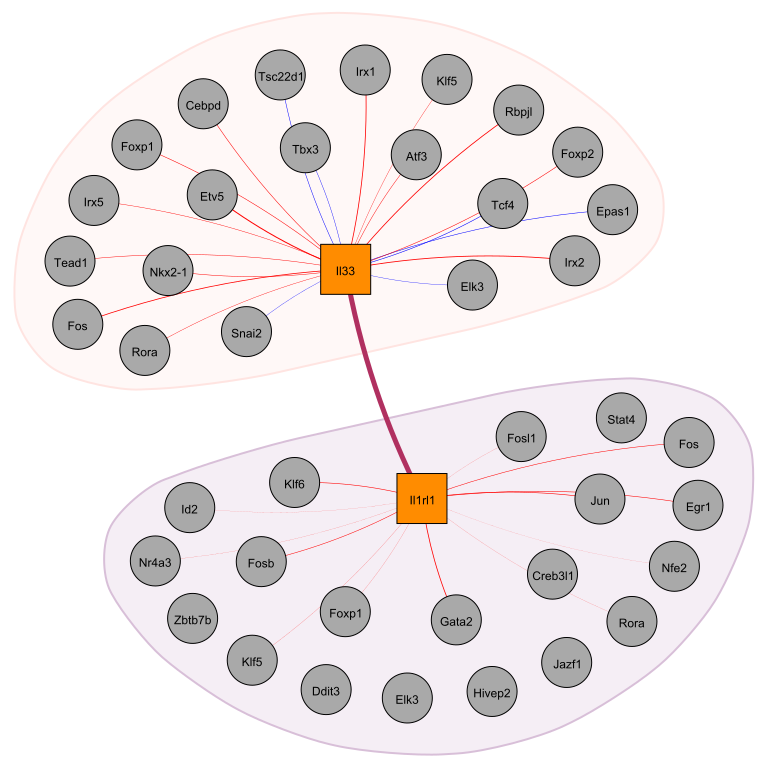

In [32]:
g1 = vis.plot_pcNet(obj1, view='sender', gene_names=[targets[0][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', gene_names=[targets[0][1]], top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[0]], verbose = True, edge_width_scale=scale_factor, 
              mark_color = ["mistyrose", "thistle"])
# , saveas = 'R_WT_AT2Baso')

In [33]:
g1 = vis.plot_pcNet(obj2, view='sender', gene_names=[targets[0][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj2, view='receiver', gene_names=[targets[0][1]], top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[0]], verbose = True, edge_width_scale=scale_factor)

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 137 TF(s) along with 1 ligand/receptor target gene(s)


ValueError: target gene Il1rl1 generated 0 edge...

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20



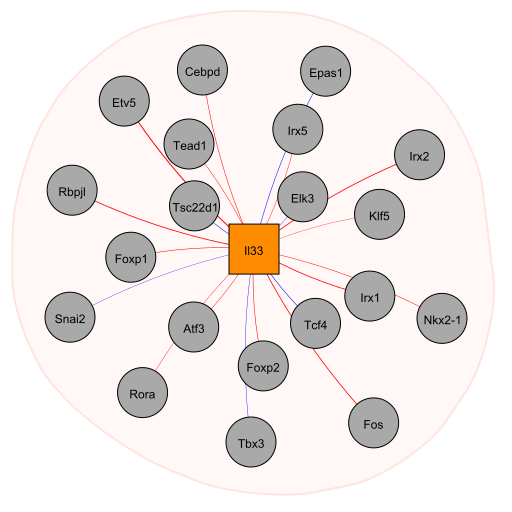

In [34]:
vis.plot_pcNet(obj2, view='sender', gene_names=[targets[0][0]], top_edges=20, show = True, verbose = True, 
               mark_color= 'mistyrose',
               edge_width_scale=scale_factor)
# , saveas='R_KO_AT2Baso')

In [35]:
scale_factor = 50

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

graphs merged: 
# of nodes: 42, # of edges: 40

edge from Edn3 to Ednrb added


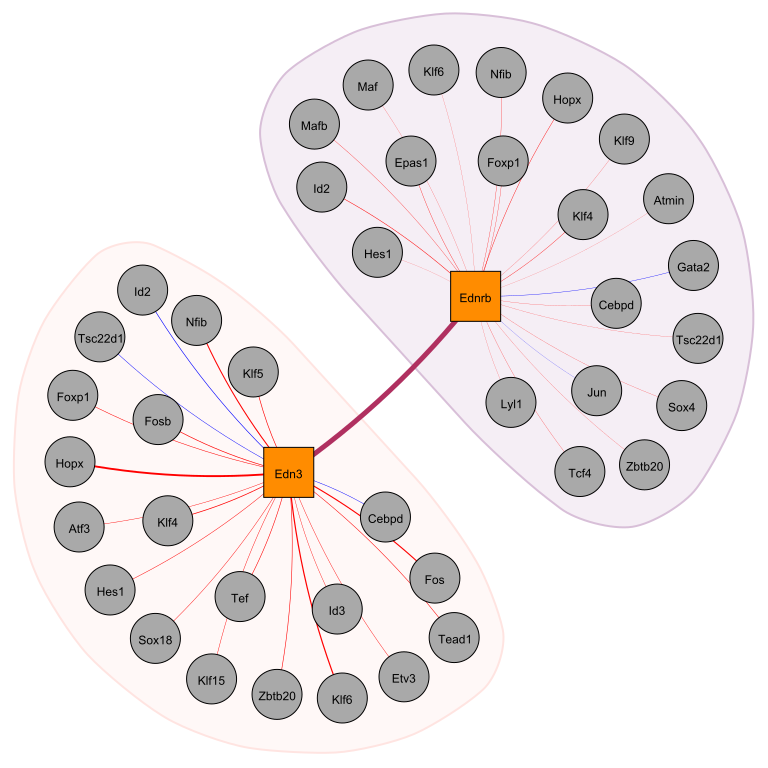

In [36]:
g1 = vis.plot_pcNet(obj1, view='sender', gene_names=[targets[1][0]], top_edges=20, show = False, verbose = True)
g2 = vis.plot_pcNet(obj1, view='receiver', gene_names=[targets[1][1]], top_edges=20, show = False, verbose = True)

vis.plot_XNet(g1, g2, Xct_pair = [targets[1]], verbose = True, edge_width_scale=scale_factor, 
              mark_color = ["mistyrose", "thistle"])
# , saveas='R_WT_EDN')

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

identified 137 TF(s) along with 1 ligand/receptor target gene(s)
undirected graph constructed: 
# of nodes: 21, # of edges: 20

graphs merged: 
# of nodes: 42, # of edges: 40

edge from Edn3 to Ednrb added


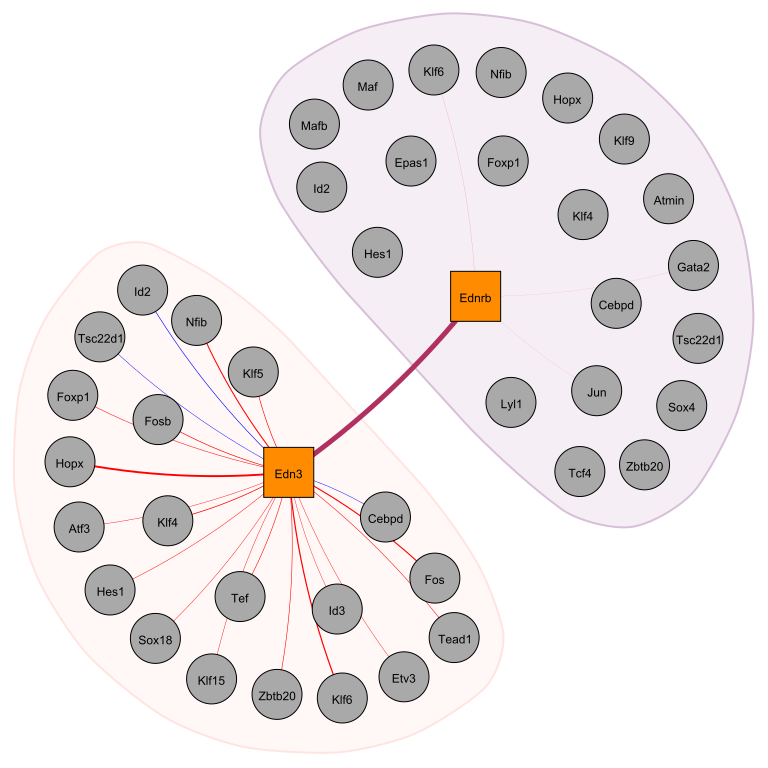

In [37]:
g11 = vis.plot_pcNet(obj2, view='sender', gene_names=[targets[1][0]], remove_isolated_nodes = False,
              match_fig=g1, show = False, verbose = True, edge_width_scale=scale_factor)

g22 = vis.plot_pcNet(obj2, view='receiver', gene_names=[targets[1][1]], 
             match_fig=g2, show = False, verbose = True, edge_width_scale=scale_factor)

vis.plot_XNet(g11, g22, Xct_pair = [targets[1]], verbose = True, edge_width_scale=scale_factor,
             mark_color = ["mistyrose", "thistle"])
# , saveas='R_KO_EDN')